# Import Packages

In [1]:
!nvidia-smi

Thu Jul  6 18:08:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 50%   52C    P2    50W / 260W |   2319MiB / 11019MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install torchviz

In [3]:
import my_utils

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vgz0bmlc because the default path (/home/emma/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
from tqdm import tqdm

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [7]:
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [9]:
from torch.autograd import Function
# from gradient_reversal import GradientReversal

In [10]:
import warnings
warnings.filterwarnings("ignore")

# Global Variables

In [11]:
## Global Variables

# DEVICE: GPU
DEVICE = torch.device("cuda", 0)

# DataFrame 檔案路徑
SOURCE_DF_FILE_PATH = "./data/train_split.csv"
TARGET_DF_FILE_PATH = "./data/NTU_DATA_train_split.csv"
TEST_DF_FILE_PATH = "./data/NTU_DATA_test_split.csv"

# BERT Embedding Tensor 儲存與載入的檔案路徑
SOURCE_EMBEDDING_FILE_PATH = "./data/train_embedding.pt"
TARGET_EMBEDDING_FILE_PATH = "./data/NTU_DATA_train_embedding.pt"
TEST_EMBEDDING_FILE_PATH = "./data/NTU_DATA_test_embedding.pt"

# Pretrained model path
PRETRAINED_MODEL_PATH = "./multitask_final_model.ckpt"
# PRETRAINED_MODEL_PATH = None

# # BERT Tokenizer
# TOKENIZER = BertTokenizer.from_pretrained("IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment")

# # # BERT Model
# BERT = BertModel.from_pretrained("IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment")
# BERT.to(DEVICE)

# Model Settings
EPOCHS = 200  # 200
########################
LR_MODEL = 5e-6
BATCH_SIZE = 128
########################
LABEL_COLUMN = "Sentiment"
LABEL_MAPPING = {"neutral": 0, "negative": 1, "positive": 2}
MAPPING = {'neutral': 0, 'negative': 1, 'positive': 2, 
           'apology': 0, 'quotation': 1, 'acknowledge': 2, 
           'thanking': 3, 'question': 4, 'disagreement': 5, 
           'greeting': 6, 'reject': 7, 'conventional-closing': 8, 
           'interjection': 9, 'agreement': 10, 'answer': 11, 
           'comfort': 12, 'command': 13, 'irony': 14, 
           'statement-non-opinion': 15, 'statement-opinion': 16, 'appreciation': 17, 
           'other': 18, 'low': 0.0, 'high': 1.0, '語者一': 0, '語者二': 1}
########################

In [12]:
my_utils.set_seed()

**** The seed has been initialized ****


# Load Dataset

In [13]:
source_df = my_utils.load_df(SOURCE_DF_FILE_PATH)
target_df = my_utils.load_df(TARGET_DF_FILE_PATH)
test_df = my_utils.load_df(TEST_DF_FILE_PATH)

The shape of the Dataset: (94187, 18)
The number of dialogues: 8086
   TV_ID Dialogue_ID Utterance_ID Speaker  Gender          Age Neuroticism  \
0      1      01_000   01_000_000     童文洁  female  middle-aged        high   
1      1      01_000   01_000_001     童文洁  female  middle-aged        high   
2      1      01_000   01_000_002      刘静  female  middle-aged         low   
3      1      01_000   01_000_003     童文洁  female  middle-aged        high   
4      1      01_001   01_001_000      刘静  female  middle-aged         low   

  Extraversion Openness Agreeableness Conscientiousness        Scene  \
0         high      low           low              high  other-venue   
1         high      low           low              high  other-venue   
2         high     high          high              high  other-venue   
3         high      low           low              high  other-venue   
4         high     high          high              high  other-venue   

  FacePosition_LU FacePosition

# Generate Training Data

In [14]:
source_df, _ = my_utils.get_dialogues_df(source_df, LABEL_COLUMN, MAPPING, MAPPING)
target_df, _ = my_utils.get_dialogues_df(target_df, LABEL_COLUMN, MAPPING, MAPPING)
test_df, _ = my_utils.get_dialogues_df(test_df, LABEL_COLUMN, MAPPING, MAPPING)

100%|██████████| 8086/8086 [00:15<00:00, 508.46it/s]


The shape of the Dialogue DataFrame: (5124, 3)


100%|██████████| 336/336 [00:05<00:00, 64.16it/s] 


The shape of the Dialogue DataFrame: (2452, 3)


100%|██████████| 96/96 [00:01<00:00, 65.10it/s]

The shape of the Dialogue DataFrame: (690, 3)


In [15]:
source_df.head()

,context,labels,demo
0,"[語者一：原指望你好好学习能上去, 語者一：结果断崖式的下滑, 語者一：你对得起我吗, 語者...","{'main_label': 1, 'future_DA_label': 4, 'senti...",你为什么一点不随妈妈
1,"[語者一：你把那一只烤鸭都吃了, 語者一：然后再多喝点鸭汤, 語者一：败败火, 語者一：然后...","{'main_label': 1, 'future_DA_label': 16, 'sent...",妈其实我都帮你记着
2,"[語者一：他有北京户口吗, 語者二：你操这个心干什么, 語者二：该你操心的你不操心, 語者二...","{'main_label': 1, 'future_DA_label': 16, 'sent...",你早跟我说不就完了吗
3,"[語者一：你操这个心干什么, 語者一：该你操心的你不操心, 語者一：不该你操心的你瞎操心, ...","{'main_label': 1, 'future_DA_label': 4, 'senti...",你问我了吗
4,"[語者一：我们校领导班组昨天专门开会, 語者一：就这个问题也进行了上会讨论, 語者一：最后一...","{'main_label': 0, 'future_DA_label': 16, 'sent...",我知道你担心什么李老师


In [16]:
target_df.head()

,context,labels,demo
0,"[語者一：您好，不好意思系統這裡沒有查到您的訂位資訊, 語者一：想請問您昨天是否有接到訂位確...","{'main_label': 0, 'future_DA_label': 18, 'sent...",那應該是因為您沒有接到確認電話
1,"[語者一：你好，我沒有接到電話欸, 語者一：但我確定我上週有在 inline 上訂位呀, 語...","{'main_label': 1, 'future_DA_label': 18, 'sent...",但我就只是剛好沒接到電話而已欸
2,"[語者一：但我確定我上週有在 inline 上訂位呀, 語者二：還是您有沒有可能是訂錯時間了...","{'main_label': 1, 'future_DA_label': 18, 'sent...",不好意思，因為這是公司的規定，我們也沒辦法
3,"[語者一：還是您有沒有可能是訂錯時間了呢？, 語者二：我確認一下, 語者二：好怪為啥網站上寫...","{'main_label': 0, 'future_DA_label': 18, 'sent...",那這樣現在現場還有座位嗎
4,"[語者一：我確認一下, 語者一：好怪為啥網站上寫我的訂位被取消了, 語者一：但我訂的時間是現...","{'main_label': 0, 'future_DA_label': 18, 'sent...",目前現場候位都已經滿了哦


In [17]:
test_df.head()

,context,labels,demo
0,"[語者一：欸欸下週旅行要怎麼去啊, 語者一：要不要一起搭高鐵, 語者二：蛤可是高鐵很貴欸, ...","{'main_label': 1, 'future_DA_label': 18, 'sent...",不要啦客運很久欸
1,"[語者一：蛤可是高鐵很貴欸, 語者一：我最近好窮, 語者二：有學生票啊, 語者二：折很多吧,...","{'main_label': 1, 'future_DA_label': 18, 'sent...",但這樣好貴我不想花那麼多錢
2,"[語者一：我最近好窮, 語者二：有學生票啊, 語者二：折很多吧, 語者一：也才85折而已還是...","{'main_label': 0, 'future_DA_label': 18, 'sent...",那不然我們搭早一點的
3,"[語者一：也才85折而已還是好貴, 語者一：還是我們就搭客運啊, 語者二：不要啦客運很久欸,...","{'main_label': 0, 'future_DA_label': 18, 'sent...",好像也不是不行
4,"[語者一：不要啦客運很久欸, 語者一：搭過去一天就都沒了, 語者二：但這樣好貴我不想花那麼多...","{'main_label': 0, 'future_DA_label': 18, 'sent...",好我看一下


In [18]:
# 確保所有文本長度一致
print(min([len(x) for x in source_df.context]))
assert min([len(x) for x in source_df.context]) == max([len(x) for x in source_df.context])

8


In [19]:
print("Source Data's Label Distribution:")
print(source_df.labels.apply(lambda x: x["main_label"]).value_counts())
print("=" * 35)
print("Test Data's Label Distribution:")
print(test_df.labels.apply(lambda x: x["main_label"]).value_counts())
print("=" * 35)

Source Data's Label Distribution:
1    2862
0    1436
2     826
Name: labels, dtype: int64
Test Data's Label Distribution:
0    281
1    253
2    156
Name: labels, dtype: int64


In [20]:
# for i in range(3):
#     print(train_df.context[i])
#     print(train_df.labels[i])
#     print("="*70)

# Calculate Embedding

In [21]:
# # # Comment these lines if we do not need to calculate the embeddings again
# target_embedding = my_utils.get_dialogues_embedding(target_df, TOKENIZER, BERT, DEVICE, TARGET_EMBEDDING_FILE_PATH)
# test_embedding = my_utils.get_dialogues_embedding(test_df, TOKENIZER, BERT, DEVICE, TEST_EMBEDDING_FILE_PATH)

In [22]:
# Load the Embeddings
source_embedding = torch.load(SOURCE_EMBEDDING_FILE_PATH)
print(source_embedding.shape)
target_embedding = torch.load(TARGET_EMBEDDING_FILE_PATH)
print(target_embedding.shape)
test_embedding = torch.load(TEST_EMBEDDING_FILE_PATH)
print(test_embedding.shape)

torch.Size([5124, 8, 768])
torch.Size([2452, 8, 768])
torch.Size([690, 8, 768])


# Model Training

In [23]:
class Dataset(Dataset):
    def __init__(self, df, embeddings):
        self.embeddings = embeddings
        self.label = torch.tensor(df.labels.apply(lambda x: x["main_label"]))
        self.speaking_order = torch.tensor(df.labels.apply(lambda x: x["speaking_order"]))

    def __len__(self):
        assert self.label.shape[0] == self.embeddings.shape[0]
        return self.label.shape[0]

    def __getitem__(self, idx):
        embeddings = self.embeddings[idx]
        label = self.label[idx]
        speaking_order = self.speaking_order[idx]
        return embeddings, label, speaking_order

In [24]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        
        self.speaker_emb = nn.Embedding(2, 768)
        self.contextual_attention_layer = nn.MultiheadAttention(768, num_heads=8, batch_first=True, dropout=0.0)
        self.layer_norm = nn.LayerNorm(768)
        self.fc = nn.Linear(768, 128)
        self.relu_1 = nn.ReLU()
        self.last_attention_layer = nn.MultiheadAttention(128, num_heads=4, batch_first=True, dropout=0.0)
        self.relu_2 = nn.ReLU()
        
        self.main_module = nn.Sequential(
            nn.Linear(128, len(LABEL_MAPPING)), # LABEL_NUM classes for main task prediction
        )
        
        self.domain_module = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
#             nn.Linear(32, 1),
        )
        
    def forward(self, embeddings, speaking_order, alpha):
        speaker_embeddings = self.speaker_emb(speaking_order)
        embeddings = embeddings + speaker_embeddings
        output, _ = self.contextual_attention_layer(embeddings, embeddings, embeddings)  # output shape: (batch_size, seq_length, hidden_dim)
        output = self.layer_norm(output)
        output = self.fc(output)
        output = self.relu_1(output)
        reverse_feature = ReverseLayerF.apply(output, alpha)
        # Last Attention
        output, _ = self.last_attention_layer(output[:, -1:, :], output, output)
        output = output.squeeze(1)
        output = self.relu_2(output)
        # reverse_feature = ReverseLayerF.apply(feature, alpha)
        main_output = self.main_module(output)  # output shape: (batch_size, num_classes) for sentiment prediction
        domain_output = self.domain_module(reverse_feature)
        return main_output, domain_output

In [25]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [26]:
# class FeatureExtractor(nn.Module):
    
#     def __init__(self):
#         super(FeatureExtractor, self).__init__()
        
#         self.speaker_emb = nn.Embedding(2, 768)
#         self.contextual_attention_layer = nn.MultiheadAttention(768, num_heads=8, batch_first=True, dropout=0.0)
#         self.layer_norm = nn.LayerNorm(768)
#         self.fc = nn.Linear(768, 128)
#         self.relu_1 = nn.ReLU()
#         self.last_attention_layer = nn.MultiheadAttention(128, num_heads=4, batch_first=True, dropout=0.0)
#         self.relu_2 = nn.ReLU()
        
#     def forward(self, embeddings, speaking_order):
#         speaker_embeddings = self.speaker_emb(speaking_order)
#         embeddings = embeddings + speaker_embeddings
#         output, _ = self.contextual_attention_layer(embeddings, embeddings, embeddings)  # output shape: (batch_size, seq_length, hidden_dim)
#         output = self.layer_norm(output)
#         output = self.fc(output)
#         output = self.relu_1(output)
#         # Last Attention
#         output, _ = self.last_attention_layer(output[:, -1:, :], output, output)
#         output = output.squeeze(1)
#         feature = self.relu_2(output)
#         return feature

In [27]:
# class LabelPredictor(nn.Module):

#     def __init__(self):
#         super(LabelPredictor, self).__init__()
        
#         self.main_module = nn.Sequential(
#             nn.Linear(128, len(LABEL_MAPPING)), # LABEL_NUM classes for main task prediction
#         )

#     def forward(self, feature):
#         main_output = self.main_module(feature)  # output shape: (batch_size, num_classes) for sentiment prediction
#         return main_output

In [28]:
# class DomainClassifier(nn.Module):

#     def __init__(self):
#         super(DomainClassifier, self).__init__()

#         self.domain_module = nn.Sequential(
#             GradientReversal(alpha=1.),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 8),
#             nn.ReLU(),
#             nn.Linear(8, 1),
#         )

#     def forward(self, feature):
#         domain_output = self.domain_module(feature)
#         return domain_output

In [29]:
# def adaptive_alpha(epoch, total_epochs):
#     p = epoch / total_epochs
#     alpha = (2 / (1 + np.exp(-10*p))) - 1
#     return alpha

In [30]:
def train(lr_model=LR_MODEL, batch_size=BATCH_SIZE, pretrained_model_path=PRETRAINED_MODEL_PATH, verbose=True):
    
    # Training and Valid Dataset
    source = Dataset(df=source_df, embeddings=source_embedding)
    target = Dataset(df=target_df, embeddings=target_embedding)
    
    # Training and Valid DataLoader
    source_dataloader = DataLoader(source, batch_size=batch_size, shuffle=True)
    target_dataloader = DataLoader(target, batch_size=batch_size, shuffle=True)
    
#     if len(source_dataloader) < len(target_dataloader):
#         new_batch_size = len(source) // len(target_dataloader)
#         source_dataloader = DataLoader(source, batch_size=new_batch_size, shuffle=True)

#     elif len(target_dataloader) < len(source_dataloader):
#         new_batch_size = len(target) // len(source_dataloader)
#         target_dataloader = DataLoader(target, batch_size=new_batch_size, shuffle=True)
    
    # Training and Validation Record
    train_label_loss_list = []
    train_domain_loss_list = []
    
    # Model
    model = Model().to(DEVICE)
#     feature_extractor = FeatureExtractor().to(DEVICE)
#     label_predictor = LabelPredictor().to(DEVICE)
#     domain_classifier = DomainClassifier().to(DEVICE)
    
    # Load pretrained weights
    if pretrained_model_path:
        
        # Load weight for Model
        pretrained_dict = torch.load(pretrained_model_path)
        model_dict = model.state_dict()
        # 1. filter out unnecessary keys
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        print("="*50)
        print(pretrained_dict.keys())
        print("="*50)
        # 2. overwrite entries in the existing state dict
        model_dict.update(pretrained_dict) 
        # 3. load the new state dict
        model.load_state_dict(model_dict)
        
#         # Load weight for feature_extractor
#         pretrained_dict = torch.load(pretrained_model_path)
#         model_dict = feature_extractor.state_dict()
#         # 1. filter out unnecessary keys
#         pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
#         print("="*50)
#         print(pretrained_dict.keys())
#         print("="*50)
#         # 2. overwrite entries in the existing state dict
#         model_dict.update(pretrained_dict) 
#         # 3. load the new state dict
#         feature_extractor.load_state_dict(model_dict)
        
#         # Load weight for label_predictor
#         pretrained_dict = torch.load(pretrained_model_path)
#         model_dict = label_predictor.state_dict()
#         # 1. filter out unnecessary keys
#         pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
#         print("="*50)
#         print(pretrained_dict.keys())
#         print("="*50)
#         # 2. overwrite entries in the existing state dict
#         model_dict.update(pretrained_dict) 
#         # 3. load the new state dict
#         label_predictor.load_state_dict(model_dict)
    
    # Loss
    label_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.BCEWithLogitsLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_model)
    
    # Gradient
    for p in model.parameters():
        p.requires_grad = True
    
#     optimizer_F = torch.optim.Adam(feature_extractor.parameters(), lr=1e-3)
#     optimizer_L = torch.optim.Adam(label_predictor.parameters(), lr=1e-3)
#     optimizer_D = torch.optim.Adam(domain_classifier.parameters(), lr=1e-3)
    
    # Training with epochs
    for epoch_num in range(EPOCHS):
        
        # adaptive alpha
#         alpha = adaptive_alpha(epoch_num, EPOCHS)

        len_dataloader = min(len(source_dataloader), len(target_dataloader))
        
        # Loss
        train_label_loss = 0.0
        train_domain_loss = 0.0
        
        # Set the state of the model to "Training"
        model.train()
#         feature_extractor.train()
#         label_predictor.train()
#         domain_classifier.train()
                
        # Training with batches
        for i, ((source_embeddings, source_label, source_speaking_order), (target_embeddings, _, target_speaking_order)) in tqdm(enumerate(zip(source_dataloader, target_dataloader)), disable=(not verbose)):
            
            # adaptive alpha
            p = float(i + epoch_num * len_dataloader) / EPOCHS / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            
            optimizer.zero_grad()
            
            # Feed the data into the model
            source_embeddings = source_embeddings.to(DEVICE)
            source_label = source_label.to(DEVICE)
            source_speaking_order = source_speaking_order.to(DEVICE)
            target_embeddings = target_embeddings.to(DEVICE)
            target_speaking_order = target_speaking_order.to(DEVICE)
            
            # Mixed the source data and target data, or it'll mislead the running params of batch_norm. 
            # (runnning mean/var of soucre and target data are different.)
#             mixed_embeddings = torch.cat([source_embeddings, target_embeddings], dim=0)
#             mixed_speaking_order = torch.cat([source_speaking_order, target_speaking_order], dim=0)
#             domain_label = torch.zeros([source_embeddings.shape[0] + target_embeddings.shape[0], 1]).to(DEVICE)
#             # set domain label of source data to be 1.
#             domain_label[:source_embeddings.shape[0]] = 1
            
            # Step 1 : train model using source data
            domain_label = torch.zeros([source_embeddings.shape[0], source_embeddings.shape[1], 1]).to(DEVICE)
            main_output, domain_output = model(source_embeddings, source_speaking_order, alpha=alpha)
            main_loss = label_criterion(main_output, source_label)
            source_domain_loss = domain_criterion(domain_output, domain_label)
            # loss = cross entropy of classification - lamb * domain binary cross entropy.
            #  The reason why using subtraction is similar to generator loss in disciminator of GAN
#             loss = label_criterion(label_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
#             train_label_loss += loss.item()
#             loss.backward()
#             optimizer_F.step()
#             optimizer_L.step()
            
            # Step 2 : train model using target data
            domain_label = torch.ones([target_embeddings.shape[0], target_embeddings.shape[1], 1]).to(DEVICE)
            _, domain_output = model(target_embeddings, target_speaking_order, alpha=alpha)
            target_domain_loss = domain_criterion(domain_output, domain_label)
            
            # Step 3 : Backward
            loss = main_loss + source_domain_loss + target_domain_loss
            loss.backward()
            optimizer.step()
            
            train_label_loss += main_loss.item()
            train_domain_loss += source_domain_loss.item()
            train_domain_loss += target_domain_loss.item()
            
            # We don't need to train feature extractor in step 1.
            # Thus we detach the feature neuron to avoid backpropgation.
#             domain_logits = domain_classifier(feature.detach())
#             loss = domain_criterion(domain_logits, domain_label)
#             train_domain_loss += loss.item()
#             loss.backward()
#             optimizer_D.step()
            
#             optimizer_D.zero_grad()
#             optimizer_F.zero_grad()
#             optimizer_L.zero_grad()
        
        train_label_loss = train_label_loss / (i+1)
        train_domain_loss = train_domain_loss / (i+1)
        
        train_label_loss_list.append(train_label_loss)
        train_domain_loss_list.append(train_domain_loss)
        
        if verbose:
            print(f"Epochs: {epoch_num + 1} | Label Loss: {train_label_loss: .3f} | Domain Loss: {train_domain_loss: .3f}")
        
    return model, train_label_loss_list, train_domain_loss_list

In [31]:
%%time
model, train_label_loss_list, train_domain_loss_list = train()

dict_keys(['speaker_emb.weight', 'contextual_attention_layer.in_proj_weight', 'contextual_attention_layer.in_proj_bias', 'contextual_attention_layer.out_proj.weight', 'contextual_attention_layer.out_proj.bias', 'layer_norm.weight', 'layer_norm.bias', 'fc.weight', 'fc.bias', 'last_attention_layer.in_proj_weight', 'last_attention_layer.in_proj_bias', 'last_attention_layer.out_proj.weight', 'last_attention_layer.out_proj.bias', 'main_module.0.weight', 'main_module.0.bias'])


20it [00:00, 60.79it/s]


Epochs: 1 | Label Loss:  0.858 | Domain Loss:  1.417


20it [00:00, 87.16it/s]


Epochs: 2 | Label Loss:  0.844 | Domain Loss:  1.416


20it [00:00, 87.38it/s]


Epochs: 3 | Label Loss:  0.823 | Domain Loss:  1.415


20it [00:00, 83.01it/s]


Epochs: 4 | Label Loss:  0.837 | Domain Loss:  1.414


20it [00:00, 54.99it/s]


Epochs: 5 | Label Loss:  0.816 | Domain Loss:  1.414


20it [00:00, 49.78it/s]


Epochs: 6 | Label Loss:  0.817 | Domain Loss:  1.414


20it [00:00, 60.52it/s]


Epochs: 7 | Label Loss:  0.824 | Domain Loss:  1.415


20it [00:00, 51.33it/s]


Epochs: 8 | Label Loss:  0.830 | Domain Loss:  1.416


20it [00:00, 54.20it/s]


Epochs: 9 | Label Loss:  0.808 | Domain Loss:  1.417


20it [00:00, 74.60it/s]


Epochs: 10 | Label Loss:  0.812 | Domain Loss:  1.418


20it [00:00, 85.15it/s]


Epochs: 11 | Label Loss:  0.820 | Domain Loss:  1.419


20it [00:00, 85.84it/s]


Epochs: 12 | Label Loss:  0.805 | Domain Loss:  1.421


20it [00:00, 81.61it/s]


Epochs: 13 | Label Loss:  0.802 | Domain Loss:  1.423


20it [00:00, 85.88it/s]


Epochs: 14 | Label Loss:  0.811 | Domain Loss:  1.423


20it [00:00, 85.55it/s]


Epochs: 15 | Label Loss:  0.799 | Domain Loss:  1.424


20it [00:00, 60.85it/s]


Epochs: 16 | Label Loss:  0.810 | Domain Loss:  1.425


20it [00:00, 62.92it/s]


Epochs: 17 | Label Loss:  0.808 | Domain Loss:  1.426


20it [00:00, 88.85it/s]


Epochs: 18 | Label Loss:  0.796 | Domain Loss:  1.427


20it [00:00, 88.61it/s]


Epochs: 19 | Label Loss:  0.805 | Domain Loss:  1.428


20it [00:00, 47.98it/s]


Epochs: 20 | Label Loss:  0.792 | Domain Loss:  1.429


20it [00:00, 58.58it/s]


Epochs: 21 | Label Loss:  0.802 | Domain Loss:  1.428


20it [00:00, 56.72it/s]


Epochs: 22 | Label Loss:  0.805 | Domain Loss:  1.429


20it [00:00, 76.68it/s]


Epochs: 23 | Label Loss:  0.810 | Domain Loss:  1.429


20it [00:00, 53.66it/s]


Epochs: 24 | Label Loss:  0.780 | Domain Loss:  1.430


20it [00:00, 85.25it/s]


Epochs: 25 | Label Loss:  0.791 | Domain Loss:  1.430


20it [00:00, 85.23it/s]


Epochs: 26 | Label Loss:  0.790 | Domain Loss:  1.429


20it [00:00, 85.61it/s]


Epochs: 27 | Label Loss:  0.792 | Domain Loss:  1.429


20it [00:00, 86.74it/s]


Epochs: 28 | Label Loss:  0.806 | Domain Loss:  1.429


20it [00:00, 76.94it/s]


Epochs: 29 | Label Loss:  0.801 | Domain Loss:  1.429


20it [00:00, 81.46it/s]


Epochs: 30 | Label Loss:  0.802 | Domain Loss:  1.428


20it [00:00, 70.80it/s]


Epochs: 31 | Label Loss:  0.781 | Domain Loss:  1.427


20it [00:00, 78.67it/s]


Epochs: 32 | Label Loss:  0.788 | Domain Loss:  1.426


20it [00:00, 77.44it/s]


Epochs: 33 | Label Loss:  0.779 | Domain Loss:  1.426


20it [00:00, 85.10it/s]


Epochs: 34 | Label Loss:  0.790 | Domain Loss:  1.425


20it [00:00, 82.64it/s]


Epochs: 35 | Label Loss:  0.793 | Domain Loss:  1.424


20it [00:00, 75.61it/s]


Epochs: 36 | Label Loss:  0.796 | Domain Loss:  1.423


20it [00:00, 85.27it/s]


Epochs: 37 | Label Loss:  0.789 | Domain Loss:  1.422


20it [00:00, 72.12it/s]


Epochs: 38 | Label Loss:  0.780 | Domain Loss:  1.422


20it [00:00, 66.63it/s]


Epochs: 39 | Label Loss:  0.782 | Domain Loss:  1.420


20it [00:00, 66.22it/s]


Epochs: 40 | Label Loss:  0.783 | Domain Loss:  1.420


20it [00:00, 66.88it/s]


Epochs: 41 | Label Loss:  0.751 | Domain Loss:  1.419


20it [00:00, 84.01it/s]


Epochs: 42 | Label Loss:  0.772 | Domain Loss:  1.418


20it [00:00, 84.09it/s]


Epochs: 43 | Label Loss:  0.775 | Domain Loss:  1.417


20it [00:00, 83.86it/s]


Epochs: 44 | Label Loss:  0.764 | Domain Loss:  1.416


20it [00:00, 73.46it/s]


Epochs: 45 | Label Loss:  0.766 | Domain Loss:  1.415


20it [00:00, 53.09it/s]


Epochs: 46 | Label Loss:  0.773 | Domain Loss:  1.414


20it [00:00, 66.56it/s]


Epochs: 47 | Label Loss:  0.761 | Domain Loss:  1.414


20it [00:00, 72.22it/s]


Epochs: 48 | Label Loss:  0.766 | Domain Loss:  1.413


20it [00:00, 66.32it/s]


Epochs: 49 | Label Loss:  0.756 | Domain Loss:  1.413


20it [00:00, 60.80it/s]


Epochs: 50 | Label Loss:  0.752 | Domain Loss:  1.412


20it [00:00, 54.81it/s]


Epochs: 51 | Label Loss:  0.763 | Domain Loss:  1.411


20it [00:00, 55.96it/s]


Epochs: 52 | Label Loss:  0.764 | Domain Loss:  1.411


20it [00:00, 57.67it/s]


Epochs: 53 | Label Loss:  0.769 | Domain Loss:  1.411


20it [00:00, 63.92it/s]


Epochs: 54 | Label Loss:  0.753 | Domain Loss:  1.410


20it [00:00, 75.25it/s]


Epochs: 55 | Label Loss:  0.744 | Domain Loss:  1.410


20it [00:00, 68.63it/s]


Epochs: 56 | Label Loss:  0.755 | Domain Loss:  1.410


20it [00:00, 66.95it/s]


Epochs: 57 | Label Loss:  0.758 | Domain Loss:  1.409


20it [00:00, 74.32it/s]


Epochs: 58 | Label Loss:  0.748 | Domain Loss:  1.409


20it [00:00, 71.75it/s]


Epochs: 59 | Label Loss:  0.744 | Domain Loss:  1.409


20it [00:00, 74.89it/s]


Epochs: 60 | Label Loss:  0.756 | Domain Loss:  1.409


20it [00:00, 86.94it/s]


Epochs: 61 | Label Loss:  0.734 | Domain Loss:  1.409


20it [00:00, 86.81it/s]


Epochs: 62 | Label Loss:  0.754 | Domain Loss:  1.408


20it [00:00, 81.78it/s]


Epochs: 63 | Label Loss:  0.743 | Domain Loss:  1.408


20it [00:00, 54.58it/s]


Epochs: 64 | Label Loss:  0.735 | Domain Loss:  1.408


20it [00:00, 70.11it/s]


Epochs: 65 | Label Loss:  0.730 | Domain Loss:  1.408


20it [00:00, 66.47it/s]


Epochs: 66 | Label Loss:  0.727 | Domain Loss:  1.408


20it [00:00, 69.95it/s]


Epochs: 67 | Label Loss:  0.728 | Domain Loss:  1.407


20it [00:00, 64.38it/s]


Epochs: 68 | Label Loss:  0.730 | Domain Loss:  1.407


20it [00:00, 59.34it/s]


Epochs: 69 | Label Loss:  0.721 | Domain Loss:  1.407


20it [00:00, 86.40it/s]


Epochs: 70 | Label Loss:  0.730 | Domain Loss:  1.407


20it [00:00, 72.01it/s]


Epochs: 71 | Label Loss:  0.734 | Domain Loss:  1.407


20it [00:00, 82.35it/s]


Epochs: 72 | Label Loss:  0.739 | Domain Loss:  1.407


20it [00:00, 75.52it/s]


Epochs: 73 | Label Loss:  0.719 | Domain Loss:  1.407


20it [00:00, 88.20it/s]


Epochs: 74 | Label Loss:  0.719 | Domain Loss:  1.407


20it [00:00, 78.54it/s]


Epochs: 75 | Label Loss:  0.719 | Domain Loss:  1.407


20it [00:00, 87.27it/s]


Epochs: 76 | Label Loss:  0.704 | Domain Loss:  1.407


20it [00:00, 62.04it/s]


Epochs: 77 | Label Loss:  0.712 | Domain Loss:  1.406


20it [00:00, 64.74it/s]


Epochs: 78 | Label Loss:  0.714 | Domain Loss:  1.407


20it [00:00, 57.97it/s]


Epochs: 79 | Label Loss:  0.714 | Domain Loss:  1.407


20it [00:00, 63.17it/s]


Epochs: 80 | Label Loss:  0.723 | Domain Loss:  1.407


20it [00:00, 63.24it/s]


Epochs: 81 | Label Loss:  0.701 | Domain Loss:  1.407


20it [00:00, 81.15it/s]


Epochs: 82 | Label Loss:  0.700 | Domain Loss:  1.407


20it [00:00, 77.32it/s]


Epochs: 83 | Label Loss:  0.704 | Domain Loss:  1.407


20it [00:00, 64.97it/s]


Epochs: 84 | Label Loss:  0.696 | Domain Loss:  1.407


20it [00:00, 67.69it/s]


Epochs: 85 | Label Loss:  0.684 | Domain Loss:  1.407


20it [00:00, 83.45it/s]


Epochs: 86 | Label Loss:  0.691 | Domain Loss:  1.407


20it [00:00, 89.68it/s]


Epochs: 87 | Label Loss:  0.708 | Domain Loss:  1.407


20it [00:00, 87.81it/s]


Epochs: 88 | Label Loss:  0.705 | Domain Loss:  1.407


20it [00:00, 89.26it/s]


Epochs: 89 | Label Loss:  0.698 | Domain Loss:  1.407


20it [00:00, 65.51it/s]


Epochs: 90 | Label Loss:  0.695 | Domain Loss:  1.408


20it [00:00, 77.27it/s]


Epochs: 91 | Label Loss:  0.686 | Domain Loss:  1.408


20it [00:00, 80.79it/s]


Epochs: 92 | Label Loss:  0.683 | Domain Loss:  1.408


20it [00:00, 89.38it/s]


Epochs: 93 | Label Loss:  0.704 | Domain Loss:  1.408


20it [00:00, 52.69it/s]


Epochs: 94 | Label Loss:  0.683 | Domain Loss:  1.408


20it [00:00, 56.33it/s]


Epochs: 95 | Label Loss:  0.694 | Domain Loss:  1.409


20it [00:00, 63.57it/s]


Epochs: 96 | Label Loss:  0.697 | Domain Loss:  1.409


20it [00:00, 87.42it/s]


Epochs: 97 | Label Loss:  0.685 | Domain Loss:  1.409


20it [00:00, 84.80it/s]


Epochs: 98 | Label Loss:  0.682 | Domain Loss:  1.409


20it [00:00, 82.54it/s]


Epochs: 99 | Label Loss:  0.662 | Domain Loss:  1.409


20it [00:00, 69.70it/s]


Epochs: 100 | Label Loss:  0.678 | Domain Loss:  1.409


20it [00:00, 82.92it/s]


Epochs: 101 | Label Loss:  0.682 | Domain Loss:  1.409


20it [00:00, 86.99it/s]


Epochs: 102 | Label Loss:  0.680 | Domain Loss:  1.409


20it [00:00, 69.36it/s]


Epochs: 103 | Label Loss:  0.677 | Domain Loss:  1.409


20it [00:00, 74.24it/s]


Epochs: 104 | Label Loss:  0.667 | Domain Loss:  1.409


20it [00:00, 73.29it/s]


Epochs: 105 | Label Loss:  0.665 | Domain Loss:  1.409


20it [00:00, 63.27it/s]


Epochs: 106 | Label Loss:  0.676 | Domain Loss:  1.409


20it [00:00, 58.92it/s]


Epochs: 107 | Label Loss:  0.669 | Domain Loss:  1.409


20it [00:00, 61.82it/s]


Epochs: 108 | Label Loss:  0.672 | Domain Loss:  1.409


20it [00:00, 79.00it/s]


Epochs: 109 | Label Loss:  0.667 | Domain Loss:  1.408


20it [00:00, 67.31it/s]


Epochs: 110 | Label Loss:  0.656 | Domain Loss:  1.408


20it [00:00, 77.01it/s]


Epochs: 111 | Label Loss:  0.661 | Domain Loss:  1.408


20it [00:00, 87.97it/s]


Epochs: 112 | Label Loss:  0.659 | Domain Loss:  1.408


20it [00:00, 76.49it/s]


Epochs: 113 | Label Loss:  0.653 | Domain Loss:  1.408


20it [00:00, 75.33it/s]


Epochs: 114 | Label Loss:  0.651 | Domain Loss:  1.407


20it [00:00, 87.66it/s]


Epochs: 115 | Label Loss:  0.665 | Domain Loss:  1.407


20it [00:00, 84.62it/s]


Epochs: 116 | Label Loss:  0.657 | Domain Loss:  1.407


20it [00:00, 83.11it/s]


Epochs: 117 | Label Loss:  0.647 | Domain Loss:  1.407


20it [00:00, 87.23it/s]


Epochs: 118 | Label Loss:  0.656 | Domain Loss:  1.407


20it [00:00, 81.89it/s]


Epochs: 119 | Label Loss:  0.651 | Domain Loss:  1.407


20it [00:00, 60.65it/s]


Epochs: 120 | Label Loss:  0.649 | Domain Loss:  1.407


20it [00:00, 87.09it/s]


Epochs: 121 | Label Loss:  0.646 | Domain Loss:  1.407


20it [00:00, 69.51it/s]


Epochs: 122 | Label Loss:  0.636 | Domain Loss:  1.407


20it [00:00, 54.45it/s]


Epochs: 123 | Label Loss:  0.638 | Domain Loss:  1.406


20it [00:00, 79.24it/s]


Epochs: 124 | Label Loss:  0.633 | Domain Loss:  1.406


20it [00:00, 69.43it/s]


Epochs: 125 | Label Loss:  0.654 | Domain Loss:  1.406


20it [00:00, 74.07it/s]


Epochs: 126 | Label Loss:  0.632 | Domain Loss:  1.406


20it [00:00, 75.43it/s]


Epochs: 127 | Label Loss:  0.642 | Domain Loss:  1.406


20it [00:00, 69.69it/s]


Epochs: 128 | Label Loss:  0.615 | Domain Loss:  1.406


20it [00:00, 71.35it/s]


Epochs: 129 | Label Loss:  0.638 | Domain Loss:  1.406


20it [00:00, 88.04it/s]


Epochs: 130 | Label Loss:  0.632 | Domain Loss:  1.406


20it [00:00, 88.77it/s]


Epochs: 131 | Label Loss:  0.627 | Domain Loss:  1.406


20it [00:00, 69.56it/s]


Epochs: 132 | Label Loss:  0.624 | Domain Loss:  1.406


20it [00:00, 73.41it/s]


Epochs: 133 | Label Loss:  0.626 | Domain Loss:  1.406


20it [00:00, 86.25it/s]


Epochs: 134 | Label Loss:  0.628 | Domain Loss:  1.406


20it [00:00, 86.20it/s]


Epochs: 135 | Label Loss:  0.627 | Domain Loss:  1.406


20it [00:00, 85.33it/s]


Epochs: 136 | Label Loss:  0.610 | Domain Loss:  1.405


20it [00:00, 83.51it/s]


Epochs: 137 | Label Loss:  0.628 | Domain Loss:  1.405


20it [00:00, 84.32it/s]


Epochs: 138 | Label Loss:  0.607 | Domain Loss:  1.405


20it [00:00, 75.77it/s]


Epochs: 139 | Label Loss:  0.597 | Domain Loss:  1.405


20it [00:00, 52.80it/s]


Epochs: 140 | Label Loss:  0.611 | Domain Loss:  1.405


20it [00:00, 54.87it/s]


Epochs: 141 | Label Loss:  0.590 | Domain Loss:  1.405


20it [00:00, 59.75it/s]


Epochs: 142 | Label Loss:  0.613 | Domain Loss:  1.405


20it [00:00, 50.79it/s]


Epochs: 143 | Label Loss:  0.576 | Domain Loss:  1.404


20it [00:00, 72.64it/s]


Epochs: 144 | Label Loss:  0.590 | Domain Loss:  1.404


20it [00:00, 60.27it/s]


Epochs: 145 | Label Loss:  0.599 | Domain Loss:  1.404


20it [00:00, 63.07it/s]


Epochs: 146 | Label Loss:  0.599 | Domain Loss:  1.404


20it [00:00, 80.11it/s]


Epochs: 147 | Label Loss:  0.585 | Domain Loss:  1.404


20it [00:00, 65.10it/s]


Epochs: 148 | Label Loss:  0.584 | Domain Loss:  1.403


20it [00:00, 75.67it/s]


Epochs: 149 | Label Loss:  0.588 | Domain Loss:  1.403


20it [00:00, 60.31it/s]


Epochs: 150 | Label Loss:  0.578 | Domain Loss:  1.403


20it [00:00, 62.03it/s]


Epochs: 151 | Label Loss:  0.585 | Domain Loss:  1.403


20it [00:00, 61.42it/s]


Epochs: 152 | Label Loss:  0.584 | Domain Loss:  1.403


20it [00:00, 62.09it/s]


Epochs: 153 | Label Loss:  0.582 | Domain Loss:  1.402


20it [00:00, 59.53it/s]


Epochs: 154 | Label Loss:  0.582 | Domain Loss:  1.402


20it [00:00, 60.76it/s]


Epochs: 155 | Label Loss:  0.559 | Domain Loss:  1.402


20it [00:00, 57.65it/s]


Epochs: 156 | Label Loss:  0.551 | Domain Loss:  1.402


20it [00:00, 47.79it/s]


Epochs: 157 | Label Loss:  0.587 | Domain Loss:  1.401


20it [00:00, 51.20it/s]


Epochs: 158 | Label Loss:  0.574 | Domain Loss:  1.401


20it [00:00, 48.82it/s]


Epochs: 159 | Label Loss:  0.576 | Domain Loss:  1.401


20it [00:00, 48.83it/s]


Epochs: 160 | Label Loss:  0.567 | Domain Loss:  1.401


20it [00:00, 48.87it/s]


Epochs: 161 | Label Loss:  0.572 | Domain Loss:  1.401


20it [00:00, 49.13it/s]


Epochs: 162 | Label Loss:  0.561 | Domain Loss:  1.400


20it [00:00, 49.60it/s]


Epochs: 163 | Label Loss:  0.552 | Domain Loss:  1.400


20it [00:00, 50.49it/s]


Epochs: 164 | Label Loss:  0.546 | Domain Loss:  1.400


20it [00:00, 54.47it/s]


Epochs: 165 | Label Loss:  0.559 | Domain Loss:  1.400


20it [00:00, 53.98it/s]


Epochs: 166 | Label Loss:  0.559 | Domain Loss:  1.400


20it [00:00, 53.23it/s]


Epochs: 167 | Label Loss:  0.540 | Domain Loss:  1.399


20it [00:00, 53.16it/s]


Epochs: 168 | Label Loss:  0.554 | Domain Loss:  1.400


20it [00:00, 52.69it/s]


Epochs: 169 | Label Loss:  0.543 | Domain Loss:  1.399


20it [00:00, 52.45it/s]


Epochs: 170 | Label Loss:  0.541 | Domain Loss:  1.399


20it [00:00, 52.47it/s]


Epochs: 171 | Label Loss:  0.546 | Domain Loss:  1.399


20it [00:00, 47.06it/s]


Epochs: 172 | Label Loss:  0.559 | Domain Loss:  1.399


20it [00:00, 46.01it/s]


Epochs: 173 | Label Loss:  0.539 | Domain Loss:  1.399


20it [00:00, 47.14it/s]


Epochs: 174 | Label Loss:  0.533 | Domain Loss:  1.399


20it [00:00, 47.12it/s]


Epochs: 175 | Label Loss:  0.529 | Domain Loss:  1.399


20it [00:00, 44.45it/s]


Epochs: 176 | Label Loss:  0.537 | Domain Loss:  1.399


20it [00:00, 45.95it/s]


Epochs: 177 | Label Loss:  0.551 | Domain Loss:  1.398


20it [00:00, 44.64it/s]


Epochs: 178 | Label Loss:  0.525 | Domain Loss:  1.398


20it [00:00, 52.28it/s]


Epochs: 179 | Label Loss:  0.537 | Domain Loss:  1.398


20it [00:00, 58.00it/s]


Epochs: 180 | Label Loss:  0.523 | Domain Loss:  1.398


20it [00:00, 56.61it/s]


Epochs: 181 | Label Loss:  0.535 | Domain Loss:  1.398


20it [00:00, 55.83it/s]


Epochs: 182 | Label Loss:  0.525 | Domain Loss:  1.398


20it [00:00, 55.66it/s]


Epochs: 183 | Label Loss:  0.504 | Domain Loss:  1.398


20it [00:00, 57.26it/s]


Epochs: 184 | Label Loss:  0.515 | Domain Loss:  1.398


20it [00:00, 56.90it/s]


Epochs: 185 | Label Loss:  0.518 | Domain Loss:  1.398


20it [00:00, 55.26it/s]


Epochs: 186 | Label Loss:  0.521 | Domain Loss:  1.398


20it [00:00, 55.38it/s]


Epochs: 187 | Label Loss:  0.504 | Domain Loss:  1.397


20it [00:00, 57.04it/s]


Epochs: 188 | Label Loss:  0.504 | Domain Loss:  1.397


20it [00:00, 57.12it/s]


Epochs: 189 | Label Loss:  0.506 | Domain Loss:  1.397


20it [00:00, 55.62it/s]


Epochs: 190 | Label Loss:  0.499 | Domain Loss:  1.397


20it [00:00, 56.28it/s]


Epochs: 191 | Label Loss:  0.493 | Domain Loss:  1.397


20it [00:00, 55.33it/s]


Epochs: 192 | Label Loss:  0.517 | Domain Loss:  1.397


20it [00:00, 55.95it/s]


Epochs: 193 | Label Loss:  0.500 | Domain Loss:  1.397


20it [00:00, 57.07it/s]


Epochs: 194 | Label Loss:  0.497 | Domain Loss:  1.397


20it [00:00, 58.34it/s]


Epochs: 195 | Label Loss:  0.497 | Domain Loss:  1.397


20it [00:00, 58.01it/s]


Epochs: 196 | Label Loss:  0.489 | Domain Loss:  1.397


20it [00:00, 57.01it/s]


Epochs: 197 | Label Loss:  0.493 | Domain Loss:  1.396


20it [00:00, 49.88it/s]


Epochs: 198 | Label Loss:  0.497 | Domain Loss:  1.397


20it [00:00, 49.92it/s]


Epochs: 199 | Label Loss:  0.497 | Domain Loss:  1.397


20it [00:00, 49.96it/s]

Epochs: 200 | Label Loss:  0.478 | Domain Loss:  1.397
CPU times: user 57.2 s, sys: 1.66 s, total: 58.9 s
Wall time: 1min 5s


# Visualization

In [32]:
sns.set()

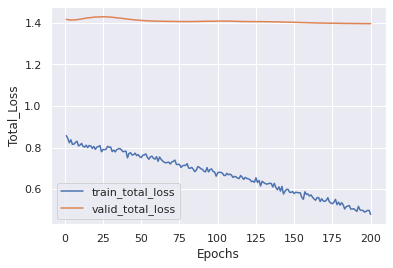

In [33]:
# Loss
my_utils.plot_result([train_label_loss_list], [train_domain_loss_list], ["total_loss"])

# Model Testing

In [34]:
def test(model):

    # Test Dataset
    test = Dataset(df=test_df, embeddings=test_embedding)
    
    # Test DataLoader
    test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
        
    # Set the state of the model to "Evaluation"
    model.eval()

    # To save the test result
    test_true = torch.tensor([])
    test_pred = torch.tensor([])

    # Test
    with torch.no_grad():

        # Test with batches
        for test_embeddings, test_label, test_speaking_order in tqdm(test_dataloader):

            # Feed the data into the model
            test_embeddings = test_embeddings.to(DEVICE)
            test_speaking_order = test_speaking_order.to(DEVICE)
            output, _ = model(test_embeddings, test_speaking_order, alpha=0)
            output = torch.argmax(torch.squeeze(output), dim=-1).cpu()

            # Save the result of each batch
            test_true = torch.cat([test_true, test_label])
            test_pred = torch.cat([test_pred, output])

        # Calculate Metrics
        test_accuracy = accuracy_score(test_true, test_pred)
        test_precision = precision_score(test_true, test_pred, average='macro')
        test_recall = recall_score(test_true, test_pred, average='macro')
        test_f1 = f1_score(test_true, test_pred, average='macro')
        
    print(f"test_accuracy: {round(test_accuracy * 100, 2)}%")
    print(f"test_precision: {round(test_precision * 100, 2)}%")
    print(f"test_recall: {round(test_recall * 100, 2)}%")
    print(f"test_f1: {round(test_f1 * 100, 2)}%")
    
    # Draw the result
    my_utils.plot_report(test_true, test_pred, list(LABEL_MAPPING.keys()))
    my_utils.plot_confusion_matrix(test_true, test_pred, list(LABEL_MAPPING.values()), list(LABEL_MAPPING.keys()))
        
    return test_accuracy, test_precision, test_recall, test_f1, test_true, test_pred

100%|██████████| 6/6 [00:00<00:00, 238.97it/s]


test_accuracy: 45.22%
test_precision: 45.1%
test_recall: 43.4%
test_f1: 42.7%
              precision    recall  f1-score   support

     neutral     0.4785    0.3559    0.4082       281
    negative     0.4433    0.6640    0.5316       253
    positive     0.4314    0.2821    0.3411       156

    accuracy                         0.4522       690
   macro avg     0.4510    0.4340    0.4270       690
weighted avg     0.4549    0.4522    0.4383       690



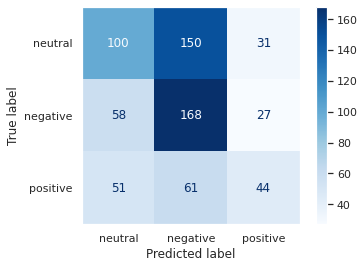

In [35]:
test_accuracy, test_precision, test_recall, test_f1, test_true, test_pred = test(model)

In [36]:
reverse_mapping = {v: k for k, v in LABEL_MAPPING.items()}
for i in range(300):
    print(test_df.context[i])
    t, p = test_df.labels[i]['main_label'], int(test_pred[i])
    flag = "X" if t != p else ""
    print(f"True: {reverse_mapping[t]} ({t})")
    print(f"Pred: {reverse_mapping[p]} ({p}) {flag}")
    print(f"Next Sentence: {test_df.demo[i]}")
    print("="*70)

['語者一：欸欸下週旅行要怎麼去啊', '語者一：要不要一起搭高鐵', '語者二：蛤可是高鐵很貴欸', '語者二：我最近好窮', '語者一：有學生票啊', '語者一：折很多吧', '語者二：也才85折而已還是好貴', '語者二：還是我們就搭客運啊']
True: negative (1)
Pred: negative (1) 
Next Sentence: 不要啦客運很久欸
['語者一：蛤可是高鐵很貴欸', '語者一：我最近好窮', '語者二：有學生票啊', '語者二：折很多吧', '語者一：也才85折而已還是好貴', '語者一：還是我們就搭客運啊', '語者二：不要啦客運很久欸', '語者二：搭過去一天就都沒了']
True: negative (1)
Pred: negative (1) 
Next Sentence: 但這樣好貴我不想花那麼多錢
['語者一：我最近好窮', '語者二：有學生票啊', '語者二：折很多吧', '語者一：也才85折而已還是好貴', '語者一：還是我們就搭客運啊', '語者二：不要啦客運很久欸', '語者二：搭過去一天就都沒了', '語者一：但這樣好貴我不想花那麼多錢']
True: neutral (0)
Pred: negative (1) X
Next Sentence: 那不然我們搭早一點的
['語者一：也才85折而已還是好貴', '語者一：還是我們就搭客運啊', '語者二：不要啦客運很久欸', '語者二：搭過去一天就都沒了', '語者一：但這樣好貴我不想花那麼多錢', '語者二：那不然我們搭早一點的', '語者二：五折的那種勒', '語者二：這樣我們還可以早點去玩']
True: neutral (0)
Pred: negative (1) X
Next Sentence: 好像也不是不行
['語者一：不要啦客運很久欸', '語者一：搭過去一天就都沒了', '語者二：但這樣好貴我不想花那麼多錢', '語者一：那不然我們搭早一點的', '語者一：五折的那種勒', '語者一：這樣我們還可以早點去玩', '語者二：好像也不是不行', '語者二：那你先查查看有幾點有五折票']
True: neutral (0)
Pred: negative (1) X
Next Sentence: 好我看一下
['語者一：但這樣好貴我不想花那麼多錢

['語者一：現在做一個到天黑都做不完', '語者二：反正現在也沒人', '語者一：等下就會有了', '語者一：一定會有懂得欣賞我的手藝的人', '語者二：一百', '語者二：賣不賣', '語者一：純手工的，真的最低價了', '語者一：不然五個1500。底線了']
True: negative (1)
Pred: positive (2) X
Next Sentence: 要不是聽你得故事覺得挺會編
['語者一：一定會有懂得欣賞我的手藝的人', '語者二：一百', '語者二：賣不賣', '語者一：純手工的，真的最低價了', '語者一：不然五個1500。底線了', '語者二：要不是聽你得故事覺得挺會編', '語者二：一個50我才要買', '語者二：最後一次 一百']
True: negative (1)
Pred: negative (1) 
Next Sentence: 不行
['語者一：一百', '語者一：賣不賣', '語者二：純手工的，真的最低價了', '語者二：不然五個1500。底線了', '語者一：要不是聽你得故事覺得挺會編', '語者一：一個50我才要買', '語者一：最後一次 一百', '語者二：不行']
True: negative (1)
Pred: positive (2) X
Next Sentence: 那就算了
['語者一：我昨天剛買的香氛片怎麼今天就降價了', '語者一：可以退差價嗎', '語者二：不好意思，沒辦法', '語者二：降價是不定期的促銷行為', '語者二：並無法因此退差價給您', '語者二：請您多多包涵', '語者一：我懂你意思', '語者一：可是我可以退貨再買對吧']
True: neutral (0)
Pred: neutral (0) 
Next Sentence: 規則上是沒問題的
['語者一：降價是不定期的促銷行為', '語者一：並無法因此退差價給您', '語者一：請您多多包涵', '語者二：我懂你意思', '語者二：可是我可以退貨再買對吧', '語者一：規則上是沒問題的', '語者一：不嫌麻煩的話沒問題', '語者一：但無法要求退差價']
True: neutral (0)
Pred: negative (1) X
Next Sentence: 可是這樣省事很多
['語者一：請您多多包涵', '語者二：我懂你意思', 

In [37]:
# 42.99%